In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import tensorflow as tf
import scipy.stats as sps
import scipy.spatial as spt
from sklearn.cross_validation import train_test_split

import edward as ed
from edward.models import Normal, Dirichlet, Multinomial, Gamma, Empirical
from tensorflow.contrib.linalg import LinearOperatorTriL
import itertools
import sys
sys.path.insert(0, tf.__path__[0] + '/contrib/distributions/python/ops')
import bijectors as bijector

/home/folzd/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


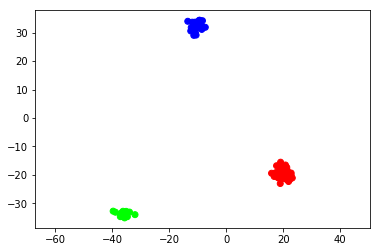

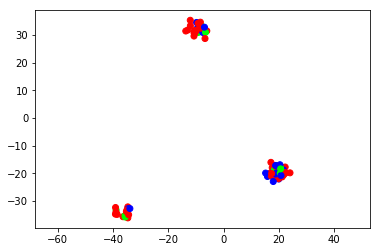

In [12]:
# from Gross et al. page 3
M = 100
K = 3
D = 2

mean_precision_shape,mean_precision_rate,obs_precision_shape,obs_precision_rate = 4.,200.,6.,10.

sess = tf.Session()
with sess.as_default():
    
    # p model
    alpha = 1
    pi = Dirichlet(np.atleast_1d(alpha*np.ones(K)).astype(np.float32))
    z = Multinomial(total_count=1.,probs=tf.reshape(tf.tile(pi,[M]),[M,K]))
    sigma2_mu_k = ed.models.InverseGamma([[mean_precision_shape]],[[mean_precision_rate]])
    sigma2_mu_d = ed.models.InverseGamma(mean_precision_shape*tf.ones([D]),mean_precision_rate*tf.ones([D]))
    sigma2_mu = tf.tile(sigma2_mu_k, [K,1])*sigma2_mu_d
    mu = ed.models.MultivariateNormalDiag(tf.zeros([K,D]), tf.sqrt(sigma2_mu))
    sigma2_obs_n = ed.models.InverseGamma([[obs_precision_shape]],[[obs_precision_rate]])
    sigma2_obs_d = ed.models.InverseGamma(obs_precision_shape*tf.ones([D]),obs_precision_rate*tf.ones([D]))
    sigma2_obs = tf.tile(sigma2_obs_n, [M,1])*sigma2_obs_d
    x = ed.models.MultivariateNormalDiag(tf.matmul(z, mu), tf.sqrt(sigma2_obs))
    
    init = tf.global_variables_initializer()
    init.run()
    
    # identify global and local latent variables
    latent_variables = x.get_ancestors()
    local_latent_variables = [lv for lv in latent_variables if lv.shape[0] == M]
    local_parent = [lv for lv in local_latent_variables[0].get_ancestors()]
    global_latent_variables = [lv for lv in latent_variables if lv not in local_latent_variables and lv not in local_parent]
        
    # sample global variables
    true_global_latent_variables = [lv.sample().eval() for lv in global_latent_variables]
    # sample M local variables M times
    true_local_latent_variables = ed.copy(z,{local_parent[0]:local_parent[0].eval()}).sample((M,)).eval()

    X_sample = np.zeros((M,M,D))
    latent_variables = dict(zip(global_latent_variables, true_global_latent_variables))
    for i in range(2):
        latent_variables.update({z:true_local_latent_variables[i]})
        X_sample[i] = ed.copy(x,latent_variables).eval() # this works only in the first iteration
        #tf.reshape(,(-1,K))
        plt.figure()
        plt.scatter(*X_sample[i].T,color=true_local_latent_variables[i])
        plt.axis('equal');

In [36]:
global_latent_variables

[<ed.RandomVariable 'InverseGamma_55/' shape=(2,) dtype=float32>,
 <ed.RandomVariable 'InverseGamma_54/' shape=(1, 1) dtype=float32>,
 <ed.RandomVariable 'InverseGamma_53/' shape=(2,) dtype=float32>,
 <ed.RandomVariable 'MultivariateNormalDiag_26/' shape=(3, 2) dtype=float32>,
 <ed.RandomVariable 'InverseGamma_52/' shape=(1, 1) dtype=float32>]

In [37]:
local_latent_variables

[<ed.RandomVariable 'Multinomial_13/' shape=(100, 3) dtype=float32>]

In [38]:
local_parent

[<ed.RandomVariable 'Dirichlet_13/' shape=(3,) dtype=float32>]

In [29]:
true_global_latent_variables

[array([[ 1.59488451]], dtype=float32),
 array([ 1.69629335,  1.39646292], dtype=float32),
 array([[ 40.41301727]], dtype=float32),
 array([ 41.52183533,  50.1121254 ], dtype=float32),
 array([ 0.23673865,  0.59517914,  0.16808222], dtype=float32),
 array([[-75.43781281, -27.86912155],
        [-35.18157959, -44.72322845],
        [-78.90581512,  95.42517853]], dtype=float32)]

In [28]:
global_latent_variables

[<ed.RandomVariable 'InverseGamma_41/' shape=(2,) dtype=float32>,
 <ed.RandomVariable 'InverseGamma_42/' shape=(1, 1) dtype=float32>,
 <ed.RandomVariable 'MultivariateNormalDiag_20/' shape=(3, 2) dtype=float32>,
 <ed.RandomVariable 'InverseGamma_43/' shape=(2,) dtype=float32>,
 <ed.RandomVariable 'Dirichlet_10/' shape=(3,) dtype=float32>,
 <ed.RandomVariable 'InverseGamma_40/' shape=(1, 1) dtype=float32>]

In [27]:
true_globals_feed

{<ed.RandomVariable 'InverseGamma_17/' shape=(2,) dtype=float32>: array([ 53.58300781,  61.585289  ], dtype=float32),
 <ed.RandomVariable 'MultivariateNormalDiag_8/' shape=(3, 2) dtype=float32>: array([[-79.66320801,  27.26038551],
        [-76.235466  , -88.34003448],
        [-66.21754456,  33.5307045 ]], dtype=float32),
 <ed.RandomVariable 'InverseGamma_16/' shape=(1, 1) dtype=float32>: array([[ 52.42448807]], dtype=float32),
 <ed.RandomVariable 'InverseGamma_18/' shape=(1, 1) dtype=float32>: array([[ 4.58286285]], dtype=float32),
 <ed.RandomVariable 'InverseGamma_19/' shape=(2,) dtype=float32>: array([ 1.72089839,  3.16688848], dtype=float32)}

In [23]:
local_parent

[<ed.RandomVariable 'Dirichlet_9/' shape=(3,) dtype=float32>]

In [8]:
tf.reset_default_graph()

In [9]:
# p model
alpha = 1
pi = Dirichlet(np.atleast_1d(alpha*np.ones(K)).astype(np.float32))
z = Multinomial(total_count=1.,probs=tf.reshape(tf.tile(pi,[M]),[M,K]))
sigma2_mu_k = ed.models.InverseGamma([[mean_precision_shape]],[[mean_precision_rate]])
sigma2_mu_d = ed.models.InverseGamma(mean_precision_shape*tf.ones([D]),mean_precision_rate*tf.ones([D]))
sigma2_mu = tf.tile(sigma2_mu_k, [K,1])*sigma2_mu_d
mu = ed.models.MultivariateNormalDiag(tf.zeros([K,D]), tf.sqrt(sigma2_mu))
sigma2_obs_n = ed.models.InverseGamma([[obs_precision_shape]],[[obs_precision_rate]])
sigma2_obs_d = ed.models.InverseGamma(obs_precision_shape*tf.ones([D]),obs_precision_rate*tf.ones([D]))
sigma2_obs = tf.tile(sigma2_obs_n, [M,1])*sigma2_obs_d
x = ed.models.MultivariateNormalDiag(tf.matmul(z, mu), tf.sqrt(sigma2_obs))

In [10]:
# q model
alpha_hat = 0.1 + tf.nn.softplus(tf.Variable(tf.random_normal([K])))
qpi = Dirichlet(alpha_hat)

#qz = Multinomial(total_count=1.,probs=tf.reshape(tf.tile(qpi,[M]),[M,K]))
#qz = Empirical(params=tf.Variable(tf.zeros([T, M, K])))

mean_precision_shape_hat = tf.nn.softplus(tf.Variable(tf.random_normal([1])))
mean_precision_rate_hat = tf.nn.softplus(tf.Variable(tf.random_normal([1])))
qsigma2_mu_k = ed.models.TransformedDistribution(
    distribution=ed.models.NormalWithSoftplusScale([mean_precision_shape_hat],[mean_precision_rate_hat]),
    bijector=bijector.Exp(),
    name="qsigma2_mu_k")
qsigma2_mu_d = ed.models.TransformedDistribution(
    distribution=ed.models.NormalWithSoftplusScale(mean_precision_shape_hat*tf.ones([D]),mean_precision_rate_hat*tf.ones([D])),
    bijector=bijector.Exp(),
    name="qsigma2_mu_d")
qsigma2_mu = tf.tile(qsigma2_mu_k, [K,1])*qsigma2_mu_d

qmu_mean = tf.Variable(tf.zeros([K,D]))
qmu = ed.models.MultivariateNormalDiag(qmu_mean, tf.sqrt(qsigma2_mu))

obs_precision_shape_hat = tf.nn.softplus(tf.Variable(tf.random_normal([1])))
obs_precision_rate_hat = tf.nn.softplus(tf.Variable(tf.random_normal([1])))
qsigma2_obs_n = ed.models.TransformedDistribution(
    distribution=ed.models.NormalWithSoftplusScale([obs_precision_shape_hat],[obs_precision_rate_hat]),
    bijector=bijector.Exp(),
    name="qsigma2_obs_n")
qsigma2_obs_d = ed.models.TransformedDistribution(
    distribution=ed.models.NormalWithSoftplusScale(obs_precision_shape_hat*tf.ones([D]),obs_precision_rate_hat*tf.ones([D])),
    bijector=bijector.Exp(),
    name="qsigma2_obs_d")
qsigma2_obs = tf.tile(qsigma2_obs_n, [M,1])*qsigma2_obs_d

In [11]:
def generator(arrays, batch_size):
  """Generate batches, one with respect to each array's first axis."""
  starts = [0] * len(arrays)  # pointers to where we are in iteration
  while True:
    batches = []
    for i, array in enumerate(arrays):
      start = starts[i]
      stop = start + batch_size
      diff = stop - array.shape[0]
      if diff <= 0:
        batch = array[start:stop]
        starts[i] += batch_size
      else:
        batch = np.concatenate((array[start:], array[:diff]))
        starts[i] = diff
      batches.append(batch)
    yield batches

In [12]:
data = generator([X_sample], M)

In [13]:
X_ph = tf.placeholder(tf.float32, [None, D])

In [14]:
#pi, qpi, z, qz, mu, qmu, sigma2_mu_k,qsigma2_mu_k, sigma2_mu_d,qsigma2_mu_d, sigma2_obs_n,qsigma2_obs_n, sigma2_obs_d,qsigma2_obs_d

In [15]:
inference = ed.KLqp({pi: qpi, mu: qmu, sigma2_mu_k:qsigma2_mu_k, sigma2_mu_d:qsigma2_mu_d, sigma2_obs_n:qsigma2_obs_n, sigma2_obs_d:qsigma2_obs_d}, data={x: X_ph, z:z_true})
inference.initialize(n_iter=5000, n_print=10, n_samples=30, optimizer='rmsprop')

In [16]:
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()

{'loss': 6886.8521, 't': 1}
{'loss': 1587.913, 't': 1001}
{'loss': 1127.9419, 't': 2001}
{'loss': 1377.5383, 't': 3001}
{'loss': 1463.8235, 't': 4001}


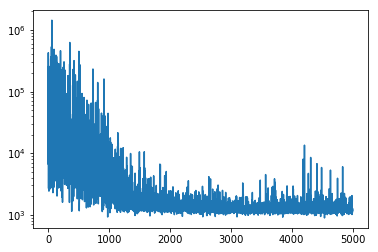

In [17]:
learning_curve = []
for _ in range(inference.n_iter):
    X_batch = next(data)[0]
    info_dict = inference.update({X_ph: X_batch})
    if _%1000 == 0:
        print(info_dict)
    learning_curve.append(info_dict['loss'])
plt.semilogy(learning_curve)

In [18]:
# %load /home/folzd/anaconda3/lib/python3.5/site-packages/edward/inferences/klqp.py

In [19]:
x_hat = ed.copy(x, {pi: qpi, z: z_true, mu: qmu, sigma2_mu_k:qsigma2_mu_k, sigma2_mu_d:qsigma2_mu_d, sigma2_obs_n:qsigma2_obs_n, sigma2_obs_d:qsigma2_obs_d})
#x_hat = ed.copy(x, {pi: qpi, z: qz, mu: qmu, sigma2_mu_k:qsigma2_mu_k, sigma2_mu_d:qsigma2_mu_d, sigma2_obs_n:qsigma2_obs_n, sigma2_obs_d:qsigma2_obs_d})

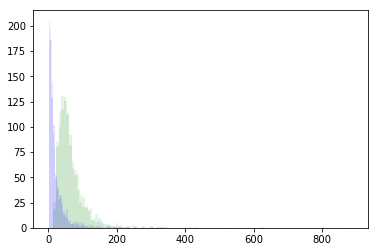

In [20]:
T = 1000
[plt.hist(var,'auto', color='g',alpha=.1) for var in sigma2_mu_d.sample(T).eval().T];
[plt.hist(var,'auto', color='b',alpha=.1) for var in qsigma2_mu_d.sample(T).eval().T];

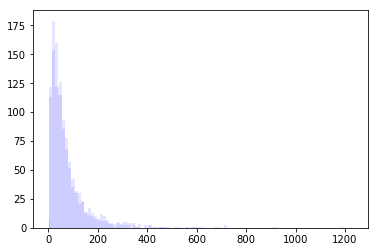

In [21]:
[plt.hist(var,'auto', color='g',alpha=.1) for var in sigma2_obs_d.sample(T).eval().T];
[plt.hist(var,'auto', color='b',alpha=.1) for var in qsigma2_obs_d.sample(T).eval().T];

In [22]:
qmu_mean.eval()

array([[ 0.10725926,  0.66487592],
       [ 0.33592147,  1.03923666],
       [ 0.66406095,  0.49517193]], dtype=float32)

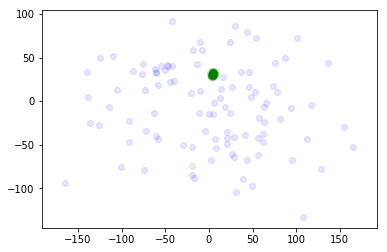

In [23]:
plt.scatter(*X_sample.T,color='g', alpha=.1)
#plt.scatter(*Gt.T,color='r')
plt.axis('equal');
X_hat_sample = x_hat.sample().eval()
plt.scatter(*X_hat_sample.T,color='b', alpha=.1)
plt.axis('equal');